# Car Price Prediction 

This notebook uses **CarPrice_Assignment.csv** as the main dataset and performs the full pipeline:

1. **Data Acquisition & Preparation**
2. **Exploratory Data Analysis & Feature Engineering**
3. **Model Development & Comparison**

## Task 1 — Data Acquisition & Preparation

In [1]:
import os, re, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore")

DATA_DIR = ""
file_assignment = os.path.join(DATA_DIR, "CarPrice_Assignment.csv")

df = pd.read_csv(file_assignment)
print("Shape:", df.shape)
df.head()

Shape: (205, 26)


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [2]:
# Normalize column names
def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    rename_map = {c: re.sub(r'\s+', '_', c.strip()).lower() for c in df.columns}
    return df.rename(columns=rename_map)

df = normalize_columns(df)

# Rename important columns
if "price" in df.columns:
    df.rename(columns={"price": "selling_price"}, inplace=True)
if "carname" in df.columns:
    df.rename(columns={"carname": "car_name"}, inplace=True)

df.head()

,car_id,symboling,car_name,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,selling_price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
# Drop duplicates and handle missing values
df = df.drop_duplicates().copy()
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

# Feature: brand from car_name
if "car_name" in df.columns:
    df["brand"] = df["car_name"].astype(str).str.split().str[0].str.lower()

print(df.shape)
df.head()

(205, 27)


,car_id,symboling,car_name,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,selling_price,brand
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0,alfa-romero
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0,alfa-romero
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0,alfa-romero
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0,audi
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0,audi


In [4]:
# Train/Test Split
target = "selling_price"
X = df.drop(columns=[target])
y = df[target]

numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (164, 26) Test shape: (41, 26)


## Task 2 — Exploratory Data Analysis & Feature Engineering

In [5]:
# New features
for cand in ["enginesize", "horsepower", "citympg", "highwaympg"]:
    if cand in df.columns:
        df[f"log_{cand}"] = np.log1p(df[cand])

if "year" in df.columns:
    current_year = pd.Timestamp.now().year
    df["car_age"] = current_year - df["year"]
    df.loc[df["car_age"] < 0, "car_age"] = df["car_age"].median()

# Outlier handling via IQR clipping
for col in df.select_dtypes(include=[np.number]).columns:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    df[col] = df[col].clip(lower, upper)

df.head()

,car_id,symboling,car_name,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,horsepower,peakrpm,citympg,highwaympg,selling_price,brand,log_enginesize,log_horsepower,log_citympg,log_highwaympg
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,111,5000,21.0,27.0,13495.0,alfa-romero,4.875197,4.718499,3.091042,3.332205
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,111,5000,21.0,27.0,16500.0,alfa-romero,4.875197,4.718499,3.091042,3.332205
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,154,5000,19.0,26.0,16500.0,alfa-romero,5.030438,5.043425,2.995732,3.295837
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,102,5500,24.0,30.0,13950.0,audi,4.700480,4.634729,3.218876,3.433987
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,115,5500,18.0,22.0,17450.0,audi,4.919981,4.753590,2.944439,3.135494


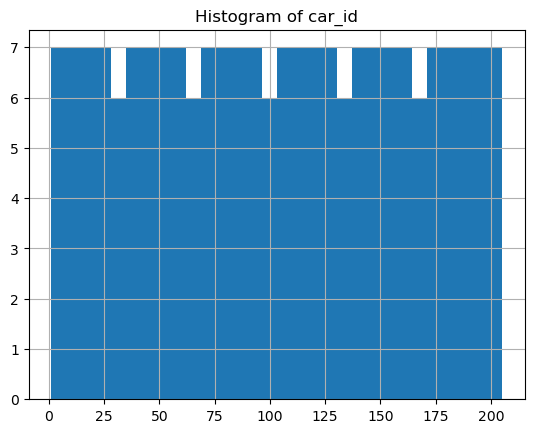

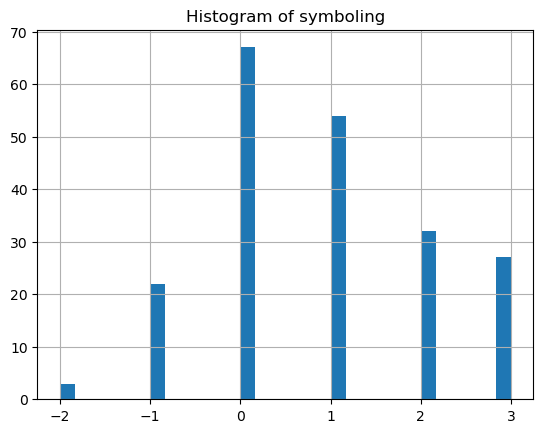

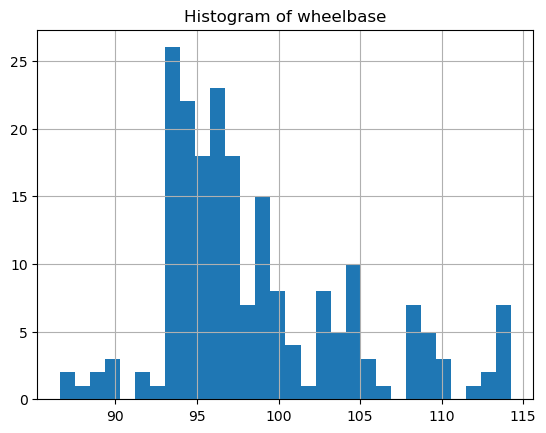

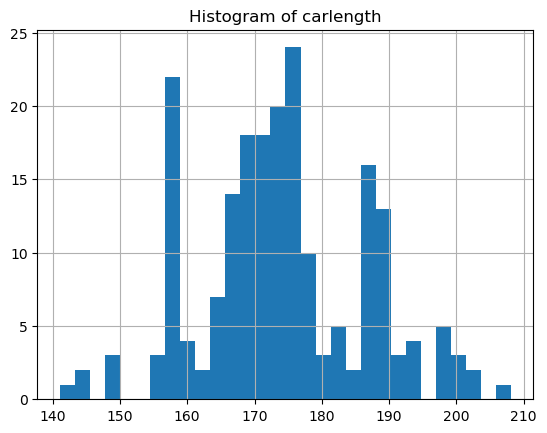

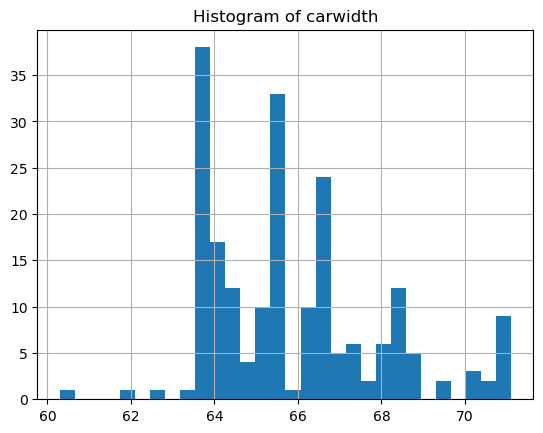

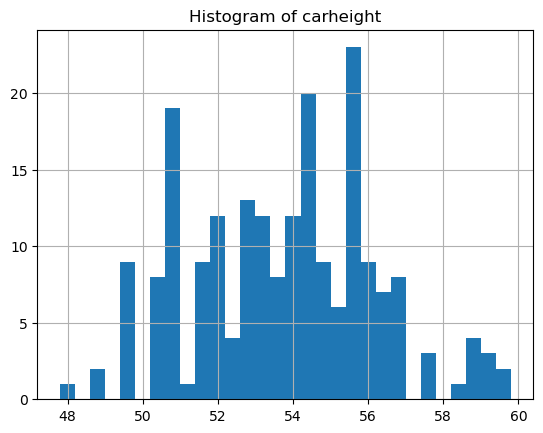

In [6]:
# Histograms
for col in df.select_dtypes(include=[np.number]).columns[:6]:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f"Histogram of {col}")
    plt.show()

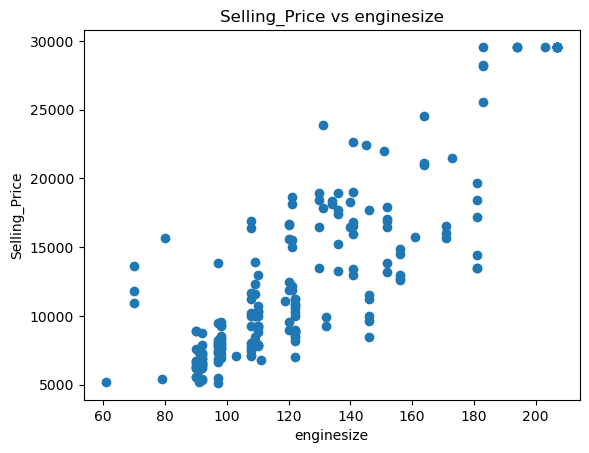

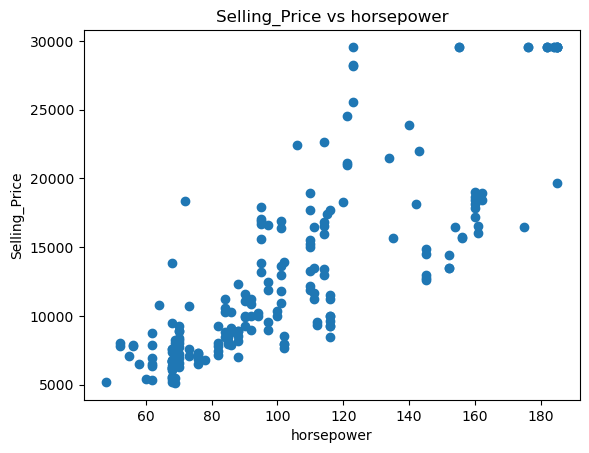

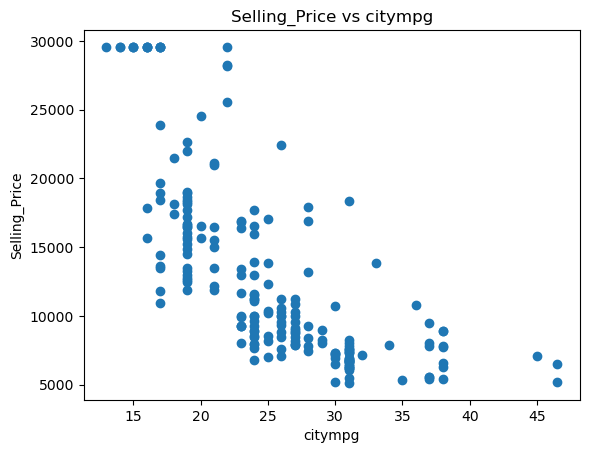

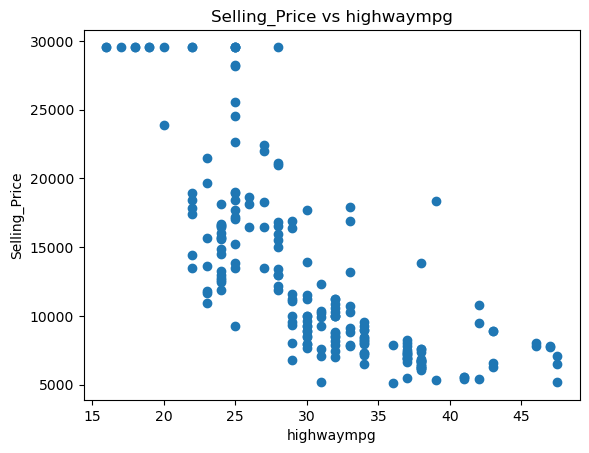

In [7]:
# Scatter vs Selling_Price
for col in [c for c in ["enginesize","horsepower","citympg","highwaympg","car_age"] if c in df.columns]:
    plt.figure()
    plt.scatter(df[col], df["selling_price"])
    plt.xlabel(col)
    plt.ylabel("Selling_Price")
    plt.title(f"Selling_Price vs {col}")
    plt.show()

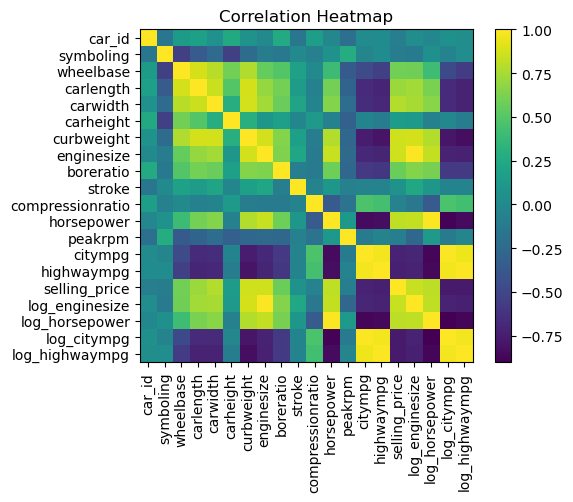

In [8]:
# Correlation heatmap
corr = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation='nearest')
plt.colorbar()
plt.title("Correlation Heatmap")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()

## Task 3 — Model Development & Comparison

In [12]:
# Train/Test again with engineered features
X = df.drop(columns=[target])
y = df[target]

numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocess = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

models = {
    "LinearRegression": LinearRegression(),
    "RidgeCV": RidgeCV(alphas=np.logspace(-3,3,13)),
    "LassoCV": LassoCV(alphas=np.logspace(-3,1,9), max_iter=5000, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=300, random_state=42)
}

def rmse_backcompat(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

results = []
for name, model in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = rmse_backcompat(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append({"Model": name, "RMSE": rmse, "R2": r2})

res_df = pd.DataFrame(results).sort_values(by="RMSE").reset_index(drop=True)
res_df


,Model,RMSE,R2
0,RandomForest,1466.928102,0.959369
1,GradientBoosting,1546.773080,0.954826
2,LassoCV,1965.425767,0.927063
3,RidgeCV,1984.351868,0.925651
4,LinearRegression,11923.953483,-1.684590


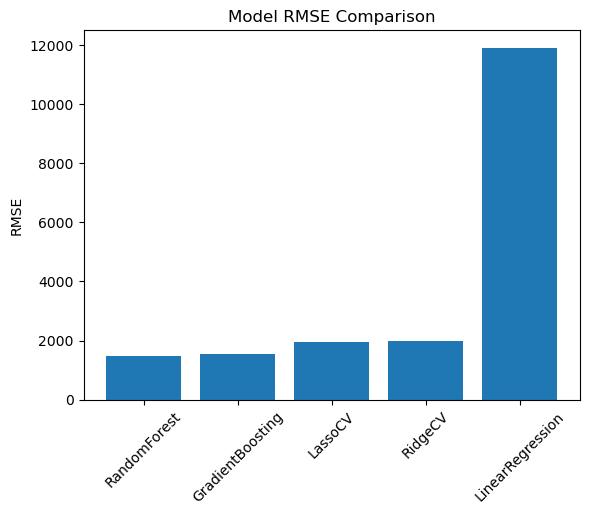

In [13]:
# RMSE Bar plot
plt.figure()
plt.bar(res_df["Model"], res_df["RMSE"])
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.show()

In [14]:
# Save cleaned dataset and metrics
CLEAN_PATH = "car_prices_cleaned.csv"
METRICS_PATH = "combined_model_metrics.csv"
df.to_csv(CLEAN_PATH, index=False)
res_df.to_csv(METRICS_PATH, index=False)
print("Saved:")
print(CLEAN_PATH)
print(METRICS_PATH)

Saved:
car_prices_cleaned.csv
combined_model_metrics.csv
